# SSD - Pytorch
This notebook shows how to compile SSD/Pytorch to AWS Inferentia (inf1 instances) using NeuronSDK. We'll use pre-trained models (Imagenet) provided by torchvision. 

**Reference:** https://pytorch.org/vision/stable/models/ssd.html

## 1) Install dependencies

In [ ]:
# Set Pip repository  to point to the Neuron repository
%pip config set global.extra-index-url https://pip.repos.neuron.amazonaws.com
# now restart the kernel

In [ ]:
#Install Neuron PyTorch
%pip install -U torch-neuron==1.10.2.2.3.0.0 neuron-cc[tensorflow] torchvision
# use --force-reinstall if you're facing some issues while loading the modules
# now restart the kernel again

## 2) Initialize libraries and prepare input samples

In [5]:
import torch
import torch.neuron
import torchvision
from torchvision.models.detection import ssd300_vgg16

IMAGE_SIZE=300 # this is the default for Imagenet

# dummy input data compatible with Imagenet(dataset)
x = torch.rand(1,3,IMAGE_SIZE,IMAGE_SIZE).float()

## 3) Adjust the model to make it compile with NeuronSDK
By default, the last layer of the model has filters that dynamically select the resulting bounding boxes,scores & labels. This adds a dynamic behavior into the model, making it incompatible with the compiler. So, we need to modify the model to remove these filters and add them to a postprocessing routine later.

In [ ]:
import types

print(f'Loading a pre-trained SSD300_VGG16')
model = ssd300_vgg16(pretrained=True)
model.eval()

## this method will overwrite the original forward and return raw data before the filters
def fake_forward(self, images):
    head_outputs,anchors,image_sizes = self.forward_(images)
    return head_outputs['bbox_regression'],head_outputs['cls_logits'],anchors

## the anchor generator uses inline ops., incompatible with the compiler
## We need to overwrite the original implementation by this one with non-inline ops
def anchor_gen_forward(self, image_list, feature_maps):
    grid_sizes = [feature_map.shape[-2:] for feature_map in feature_maps]    
    image_size = image_list.tensors.shape[-2:]
    image_size = float(image_size[0]),float(image_size[1])
    
    
    dtype, device = feature_maps[0].dtype, feature_maps[0].device
    default_boxes = self._grid_default_boxes(grid_sizes, image_size, dtype=dtype)
    default_boxes = default_boxes.to(device)
    
    dboxes = []
    for _ in image_list.image_sizes:        
        dboxes_in_image = default_boxes
        if self.inplace: # this is the original implementation
            dboxes_in_image = torch.cat([dboxes_in_image[:, :2] - 0.5 * dboxes_in_image[:, 2:],
                                         dboxes_in_image[:, :2] + 0.5 * dboxes_in_image[:, 2:]], -1)
            dboxes_in_image[:, 0::2] *= image_size[1]
            dboxes_in_image[:, 1::2] *= image_size[0]
        else: # the following code doesn't use inline ops to make NeuronSDK happy
            x,y = dboxes_in_image.split((2,2),-1)
            
            dboxes_in_image = torch.cat([x - 0.5 * y,
                                         x + 0.5 * y], -1)
            x1,y1,x2,y2 = dboxes_in_image.split((1,1,1,1), -1)
            dboxes_in_image = torch.cat([x1 * image_size[0], y1 * image_size[1],
                                         x2 * image_size[0], y2 * image_size[1]], -1)
        dboxes.append(dboxes_in_image)
    return dboxes

if not hasattr(model, 'postprocess_detections_'):     
    model.postprocess_detections_ = model.postprocess_detections
if not hasattr(model.transform, 'postprocess_'): 
    model.transform.postprocess_ = model.transform.postprocess    
if not hasattr(model, 'forward_'):
    model.forward_ = model.forward
if not hasattr(model.anchor_generator, 'inplace'):
    model.anchor_generator.inplace = False

model.postprocess_detections = types.MethodType(lambda self,x,y,z: (x,y,z), model)
model.transform.postprocess = types.MethodType(lambda self,x,y,z: x, model.transform)
# replace inline ops
model.anchor_generator.forward = types.MethodType(anchor_gen_forward, model.anchor_generator)
model.forward = types.MethodType(fake_forward, model)

## 4) Load the modified model and check if it is .jit traceable now

In [ ]:
y = model(x) # warmup the model
try:
    traced_model = torch.jit.trace(model, x)
    print("Cool! Model is jit traceable")
except Exception as e:
    print("Ops. Something went wrong. Model is not traceable")
## ok the model is .jit traceable. now let's compile it with NeuronSDK

## 5) Analyze & compile the model for Inferentia with NeuronSDK

Neuron Check Model tool provides user with basic information about the compiled and uncompiled model’s operations without the use of TensorBoard-Neuron.  
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-tools/tutorial-neuron-check-model.html


The PyTorch-Neuron trace Python API provides a method to generate PyTorch models for execution on Inferentia, which can be serialized as TorchScript. It is analogous to torch.jit.trace() function in PyTorch.   
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-compilation-python-api.html?highlight=trace

In [ ]:
torch.neuron.analyze_model(model, x)

In [ ]:
neuron_model = torch.neuron.trace(model, x)
neuron_model.save("neuron_ssd300vgg16.pt")

In [ ]:
y = neuron_model(x) # warmup
%timeit neuron_model(x)

## 6) Rebuild the forward and add back post-processing
We removed the post-processing functions from the last layer at the beginning of this notebook. Now we need to add them back to the model before using it.

In [ ]:
import types
import torch
import torch.neuron
import torchvision
from torchvision.models.detection import ssd300_vgg16

print(f'Loading a pre-trained SSD300_VGG16')
accel_model = ssd300_vgg16(pretrained=True)
accel_model.eval()

def neuron_forward(self,images):
    image_sizes = [i.shape[1:] for i in images]
    bbox_regression,cls_logits,anchors = self.forward_neuron(images)
    head_outputs = {'bbox_regression': bbox_regression, 'cls_logits': cls_logits}
    # get the original image sizes
    original_image_sizes: List[Tuple[int, int]] = []
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))
    detections = self.postprocess_detections(head_outputs,anchors,image_sizes)
    detections = self.transform.postprocess(detections, image_sizes, original_image_sizes)    
    return detections

if not hasattr(accel_model, 'forward_'):
    accel_model.forward_ = accel_model.forward

accel_model.forward_neuron = torch.jit.load("neuron_ssd300vgg16.pt")
accel_model.forward = types.MethodType(neuron_forward, accel_model)

## 7) A simple test to check the predictions

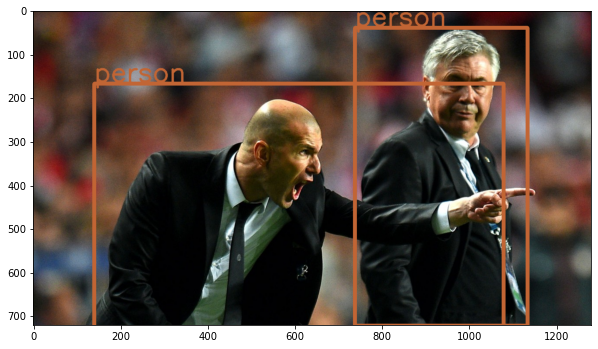

In [3]:
%matplotlib inline
import sys
if '..' not in sys.path: sys.path.append('..')
import cv2
import numpy as np
import matplotlib.pyplot as plt

from common import processing

# load a sample image
img = processing.load_sample_imgB()
x = processing.preprocess_coco(img,img_size=(300,300), disable_letterbox=True)
x = torch.from_numpy(x)

labels = processing.coco91_labels

outputs = accel_model(x)

detection_threshold=0.5

# get all the predicited class names
pred_classes = [labels[i] for i in outputs[0]['labels'].numpy()]
# get score for all the predicted objects
pred_scores = outputs[0]['scores'].numpy()
# get all the predicted bounding boxes
pred_bboxes = outputs[0]['boxes'].numpy()
# get boxes above the threshold score
boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)

out_image = processing.draw_boxes(boxes, pred_classes, outputs[0]['labels'], img)

plt.figure(figsize=(10,10))
plt.imshow(out_image)